## Assignmnet Week 10

[MLFlow][1] is an open source framework used for MLOps which provides tools for development, tracking experiments, managing models and deployment.

In this assignment, MLFlow is used to capture and log below attributes from a OpenAI chat completion task (model used - gpt-4o-mini). User are promted to enter their query and then api call to OpenAI chat completion is initiated. After receiving the response from the OpenAI gpt-40-mini model, the below attributes and performance metrics are logged by the MLFlow logging capability.

- prompt tokens
- completion tokens
- conversation tokens
- request latency (time taken to send and receive response from OpenAI gpt model)
- request count (count of request sent to OpenAI)

Furthermore, the below parameters used in the OpenAI api call is also captured by MLFlow.

- Model used
- Temperature
- Top P
- Frequency Penalty
- Presency Penalty


[1]: https://mlflow.org/docs/latest/getting-started/intro-quickstart/index.html

Docker containers are used to run MLFlow server and the port used for MLFLow is 8080

In [6]:
import os
import time
import mlflow
from openai import OpenAI
import tiktoken as tk
from colorama import Fore, Style, init
import json

As the mlflow is running locally on port 8080, the mlflow uri is `http://localhost:8080`

In [11]:
MLFLOW_URI = "http://localhost:8080"

Setting the Model parameters for Open API API call

In [17]:
MODEL = "gpt-4o-mini"
TEMPERATURE = 0.7
TOP_P = 1
FREQUENCY_PENALTY = 0
PRESENCE_PENALTY = 0
MAX_TOKENS = 800
DEBUG = False

In [13]:
# Initialize colorama
init()

# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]

os.environ["OPENAI_API_KEY"] = api_key
# Initialize OpenAI client
client = OpenAI()

Need to set `tracking server` for MlFlow. For this execution, mlflow server is running locally and it is listening on port `8080`. Also need to provide an experiment name for mlflow to log model metadata and performance metrics.

In [14]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment("week10_assignment") 

2025/02/07 14:34:06 INFO mlflow.tracking.fluent: Experiment with name 'week10_assignment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow/artifacts/260420388858552430', creation_time=1738956846799, experiment_id='260420388858552430', last_update_time=1738956846799, lifecycle_stage='active', name='week10_assignment', tags={}>

MlFlow `log_metric` method was used to log the performance metrics of OpenAI api call for chat completion task, and `log_params` method was used to log the parameters used in the api call.

In [15]:
# Print user input and AI output with colors
def print_user_input(text):
    print(f"{Fore.GREEN}You: {Style.RESET_ALL}", text)

def print_ai_output(text):
    print(f"{Fore.BLUE}AI Assistant:{Style.RESET_ALL}", text)

# count tokens
def count_tokens(string: str, encoding_name="cl100k_base") -> int:
    # Get the encoding
    encoding = tk.get_encoding(encoding_name)
    
    # Encode the string
    encoded_string = encoding.encode(string, disallowed_special=())

    # Count the number of tokens
    num_tokens = len(encoded_string)
    return num_tokens

# Generate text using OpenAI API
def generate_text(conversation, max_tokens=100)->str:
    # Generate text using OpenAI API
    start_time = time.time()
    response = client.chat.completions.create(
        model=MODEL,
        messages=conversation,
        temperature=TEMPERATURE,
        max_tokens=max_tokens,
        top_p=TOP_P,
        frequency_penalty=FREQUENCY_PENALTY,
        presence_penalty=PRESENCE_PENALTY
    )
    latency = time.time() - start_time
    message_response = response.choices[0].message.content
    
    # Count tokens in the prompt and the completion
    prompt_tokens = count_tokens(conversation[-1]['content'])
    conversation_tokens = count_tokens(str(conversation))
    completion_tokens = count_tokens(message_response)
    
    run = mlflow.active_run()
    if DEBUG:    
        print(f"Run ID: {run.info.run_id}")
        input("Press Enter to continue...")

    mlflow.log_metrics({
        "request_count": 1,
        "request_latency": latency,
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "conversation_tokens": conversation_tokens
    })
    
    mlflow.log_params({
        "model": MODEL,
        "temperature": TEMPERATURE,
        "top_p": TOP_P,
        "frequency_penalty": FREQUENCY_PENALTY,
        "presence_penalty": PRESENCE_PENALTY
    })

    return message_response


MLFlow `start_run` method is used to start a new run of the experiment and log metrics and parameters defined in above function.

In [18]:
mlflow.autolog()

# Start a new MLflow run
with mlflow.start_run() as run:
    conversation = [
        {"role": "system", "content": "You are a helpful assistant."},
    ]

    while True:
        user_input = input("User: ")
        if user_input.lower() in ["exit", "quit", "q", "e"]:
            break

        conversation.append({"role": "user", "content": user_input})
        ai_output = generate_text(conversation, MAX_TOKENS)
        print_ai_output(ai_output)
        conversation.append({"role": "assistant", "content": ai_output})

2025/02/07 14:37:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for openai.


User:  recipe for cardamom tea


2025/02/07 14:38:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for langchain.
2025/02/07 14:38:19 WARNING mlflow.tracing.export.mlflow: Failed to log trace to MLflow backend. Error: [Errno 30] Read-only file system: '/mlflow'. For full traceback, set logging level to debug.
2025/02/07 14:38:22 WARNING mlflow.openai._openai_autolog: Failed to log model due to error: [Errno 30] Read-only file system: '/mlflow'


AI Assistant: Certainly! Here's a simple recipe for making delicious cardamom tea:

### Cardamom Tea Recipe

#### Ingredients:
- 2 cups water
- 2-3 green cardamom pods (or to taste)
- 1-2 teaspoons loose black tea or 1-2 tea bags (Assam or Darjeeling work well)
- Milk (optional, to taste)
- Sugar or sweetener (optional, to taste)

#### Instructions:

1. **Crush the Cardamom:**
   - Lightly crush the cardamom pods using a mortar and pestle or the back of a spoon. This helps to release the flavor.

2. **Boil Water:**
   - In a saucepan, bring 2 cups of water to a boil.

3. **Add Cardamom:**
   - Once the water is boiling, add the crushed cardamom pods to the water. Let it simmer for about 2-3 minutes to infuse the flavor.

4. **Add Tea:**
   - Add the loose black tea or the tea bags to the boiling water. Let it steep for 3-5 minutes, depending on how strong you like your tea.

5. **Add Milk (Optional):**
   - If you prefer your tea with milk, add it at this stage. You can adjust the quan

User:  q


🏃 View run whimsical-ant-922 at: http://localhost:8080/#/experiments/260420388858552430/runs/a2df44b2d5a841058c0da5309faae13c
🧪 View experiment at: http://localhost:8080/#/experiments/260420388858552430


Trace(request_id=bc4d3e43e21442c3aff05bd4c9e3a995)

We can see the experiments in MlFlow server running locally. There were two runs executed for this `week10_assisnment` experiment.

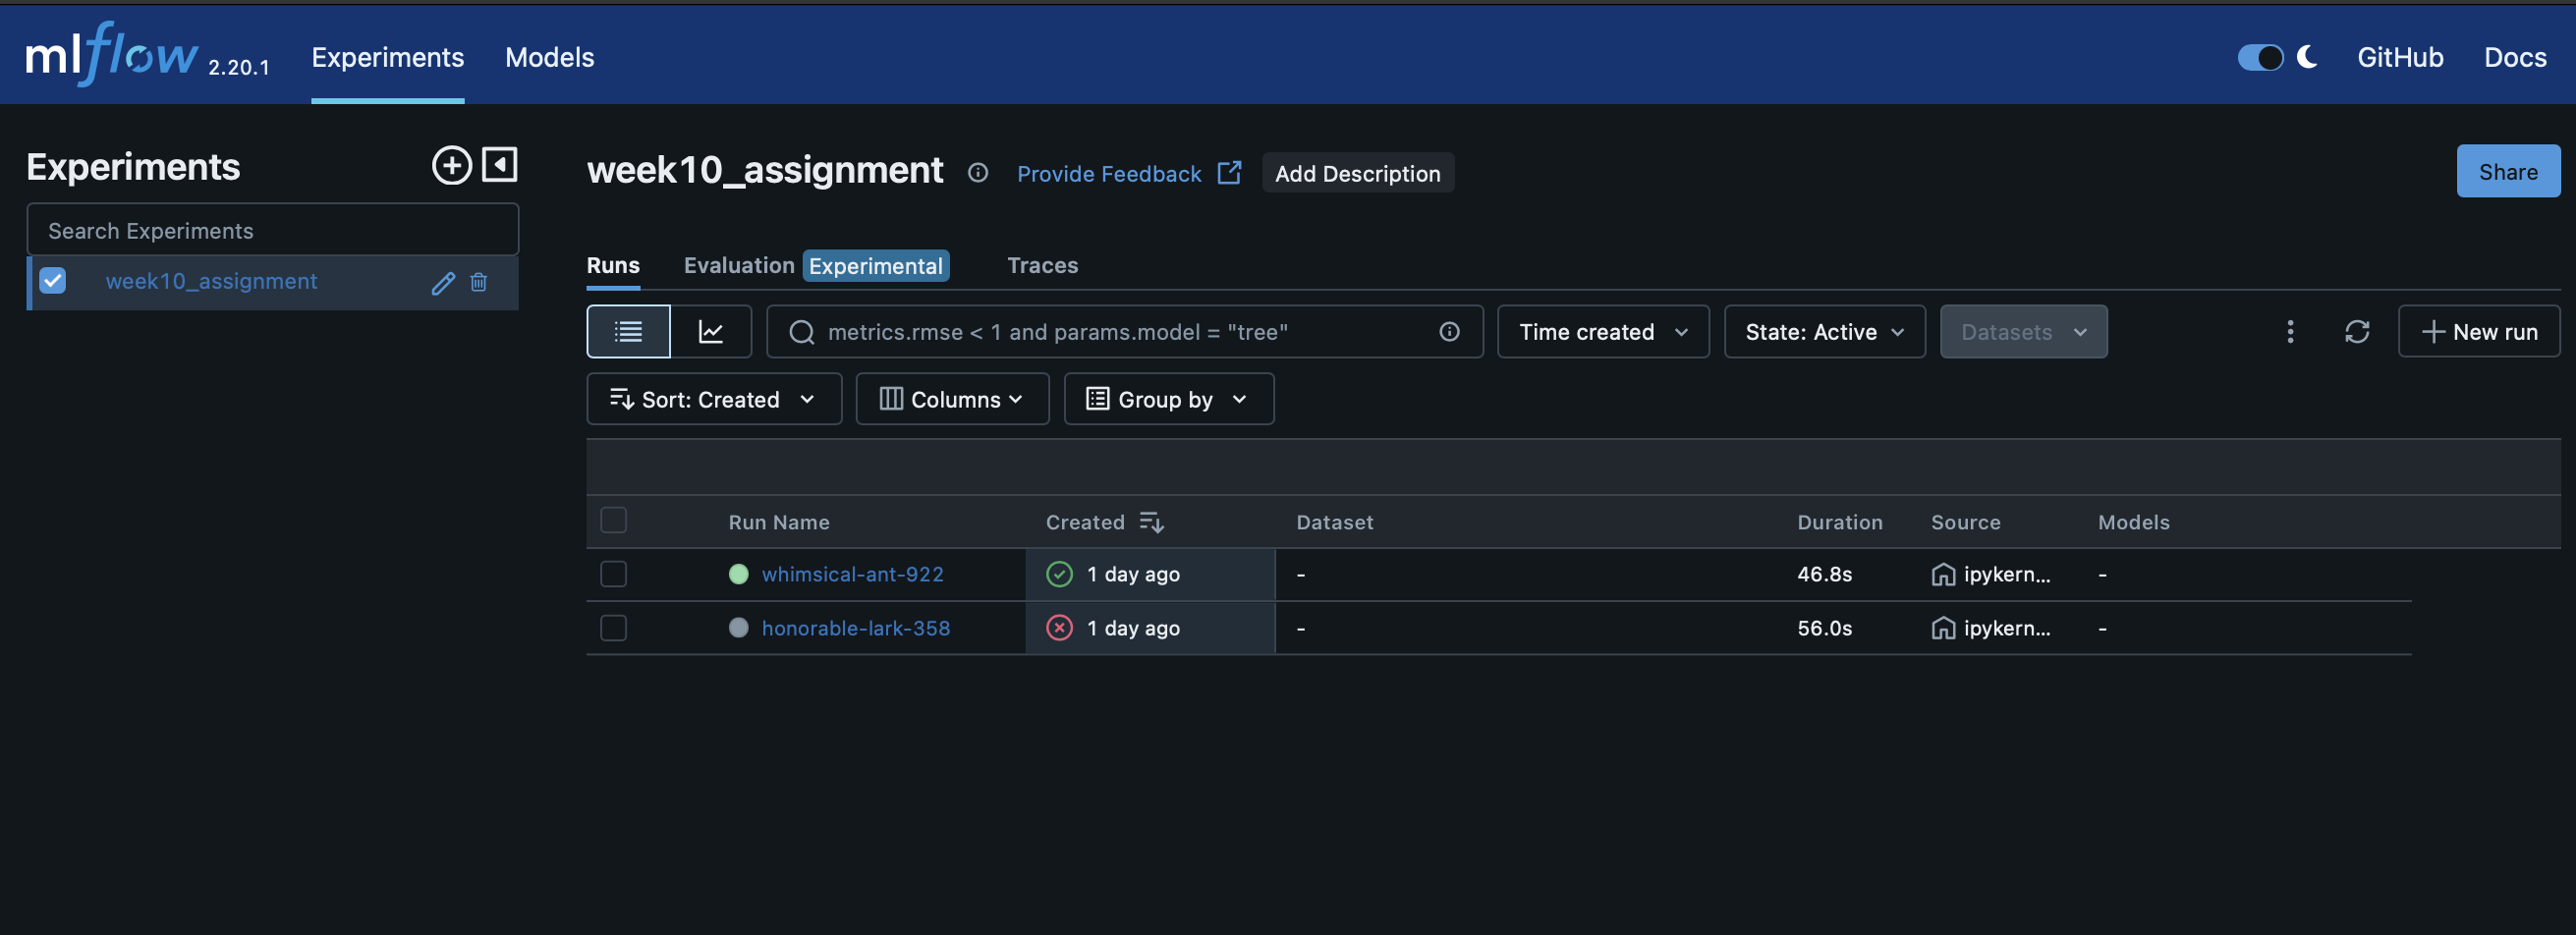

We can see all the `parameters` and `metrics` captured by MLFlow as defined in `log_params` and `log_metrics` functions.

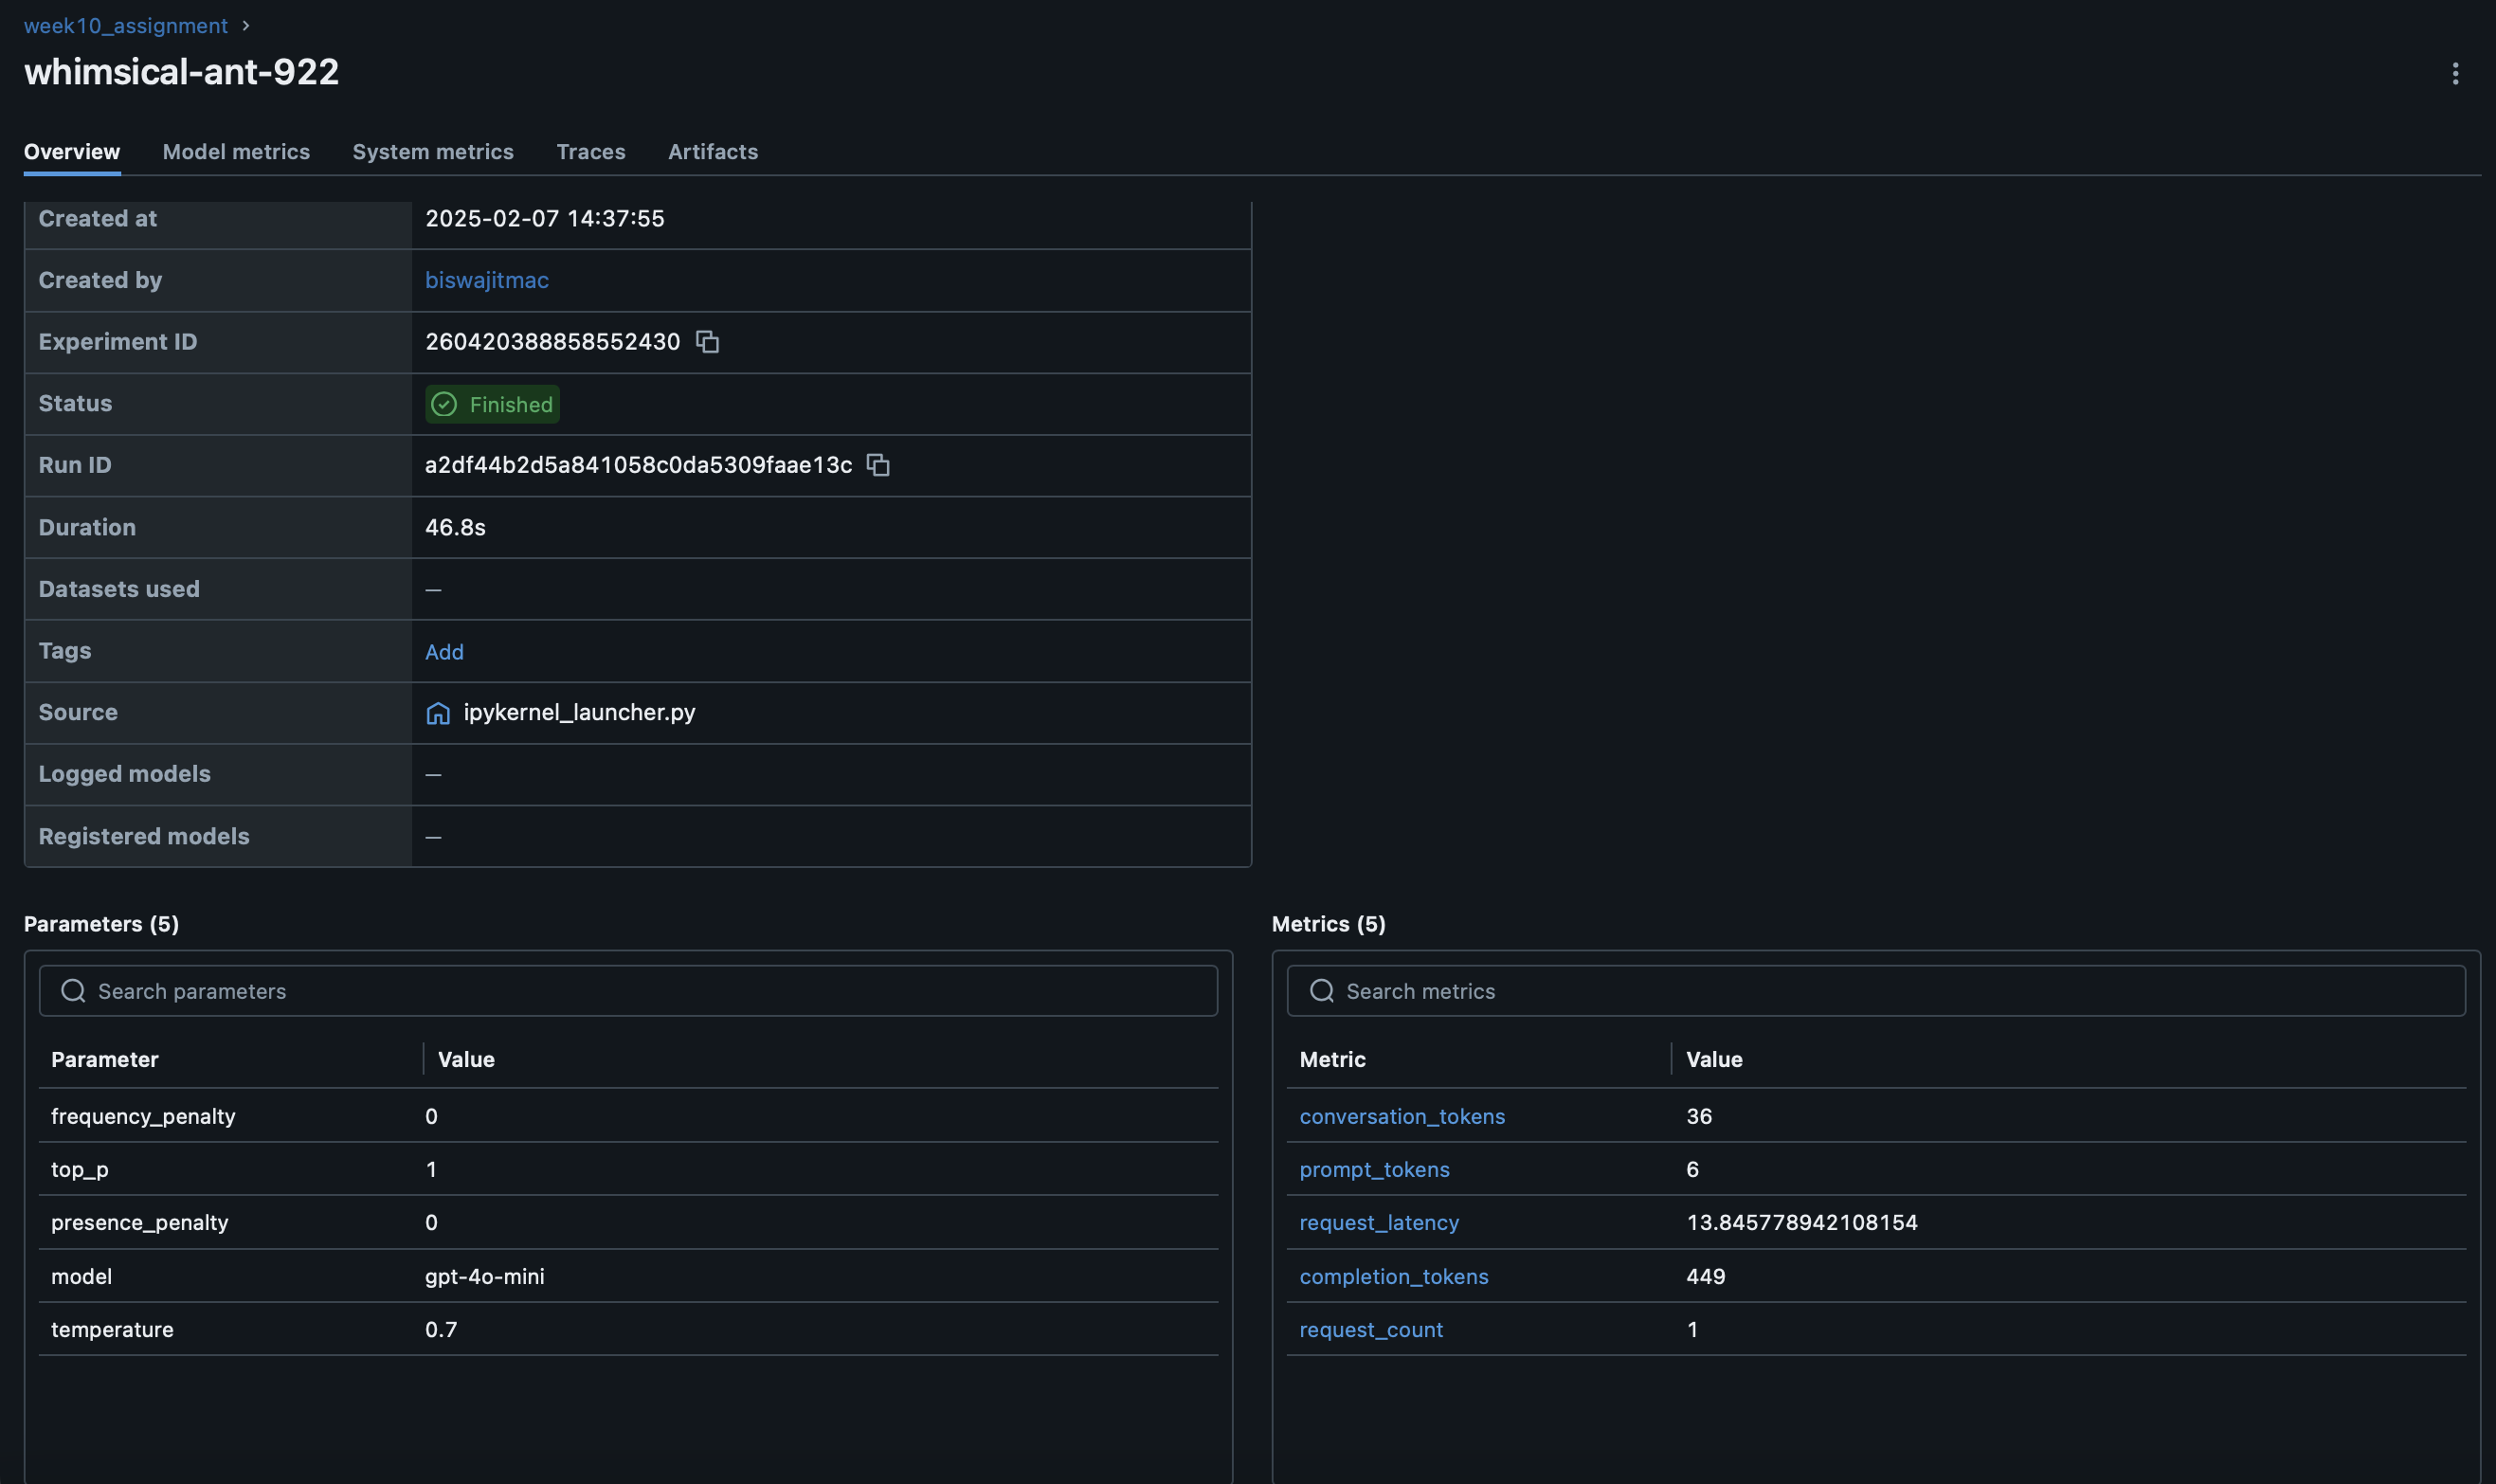

We see that `gpt-4o-mini` model was used with $0.7$ temperature and $1$ top_p. The OpenAI api call had a lanency of about $14$ seconds and consumed $449$ completion tokens. Other parameters and metris are also avalibale for reference.

The model metrics are also avaliable as _graphical charts_ on MLFlow.

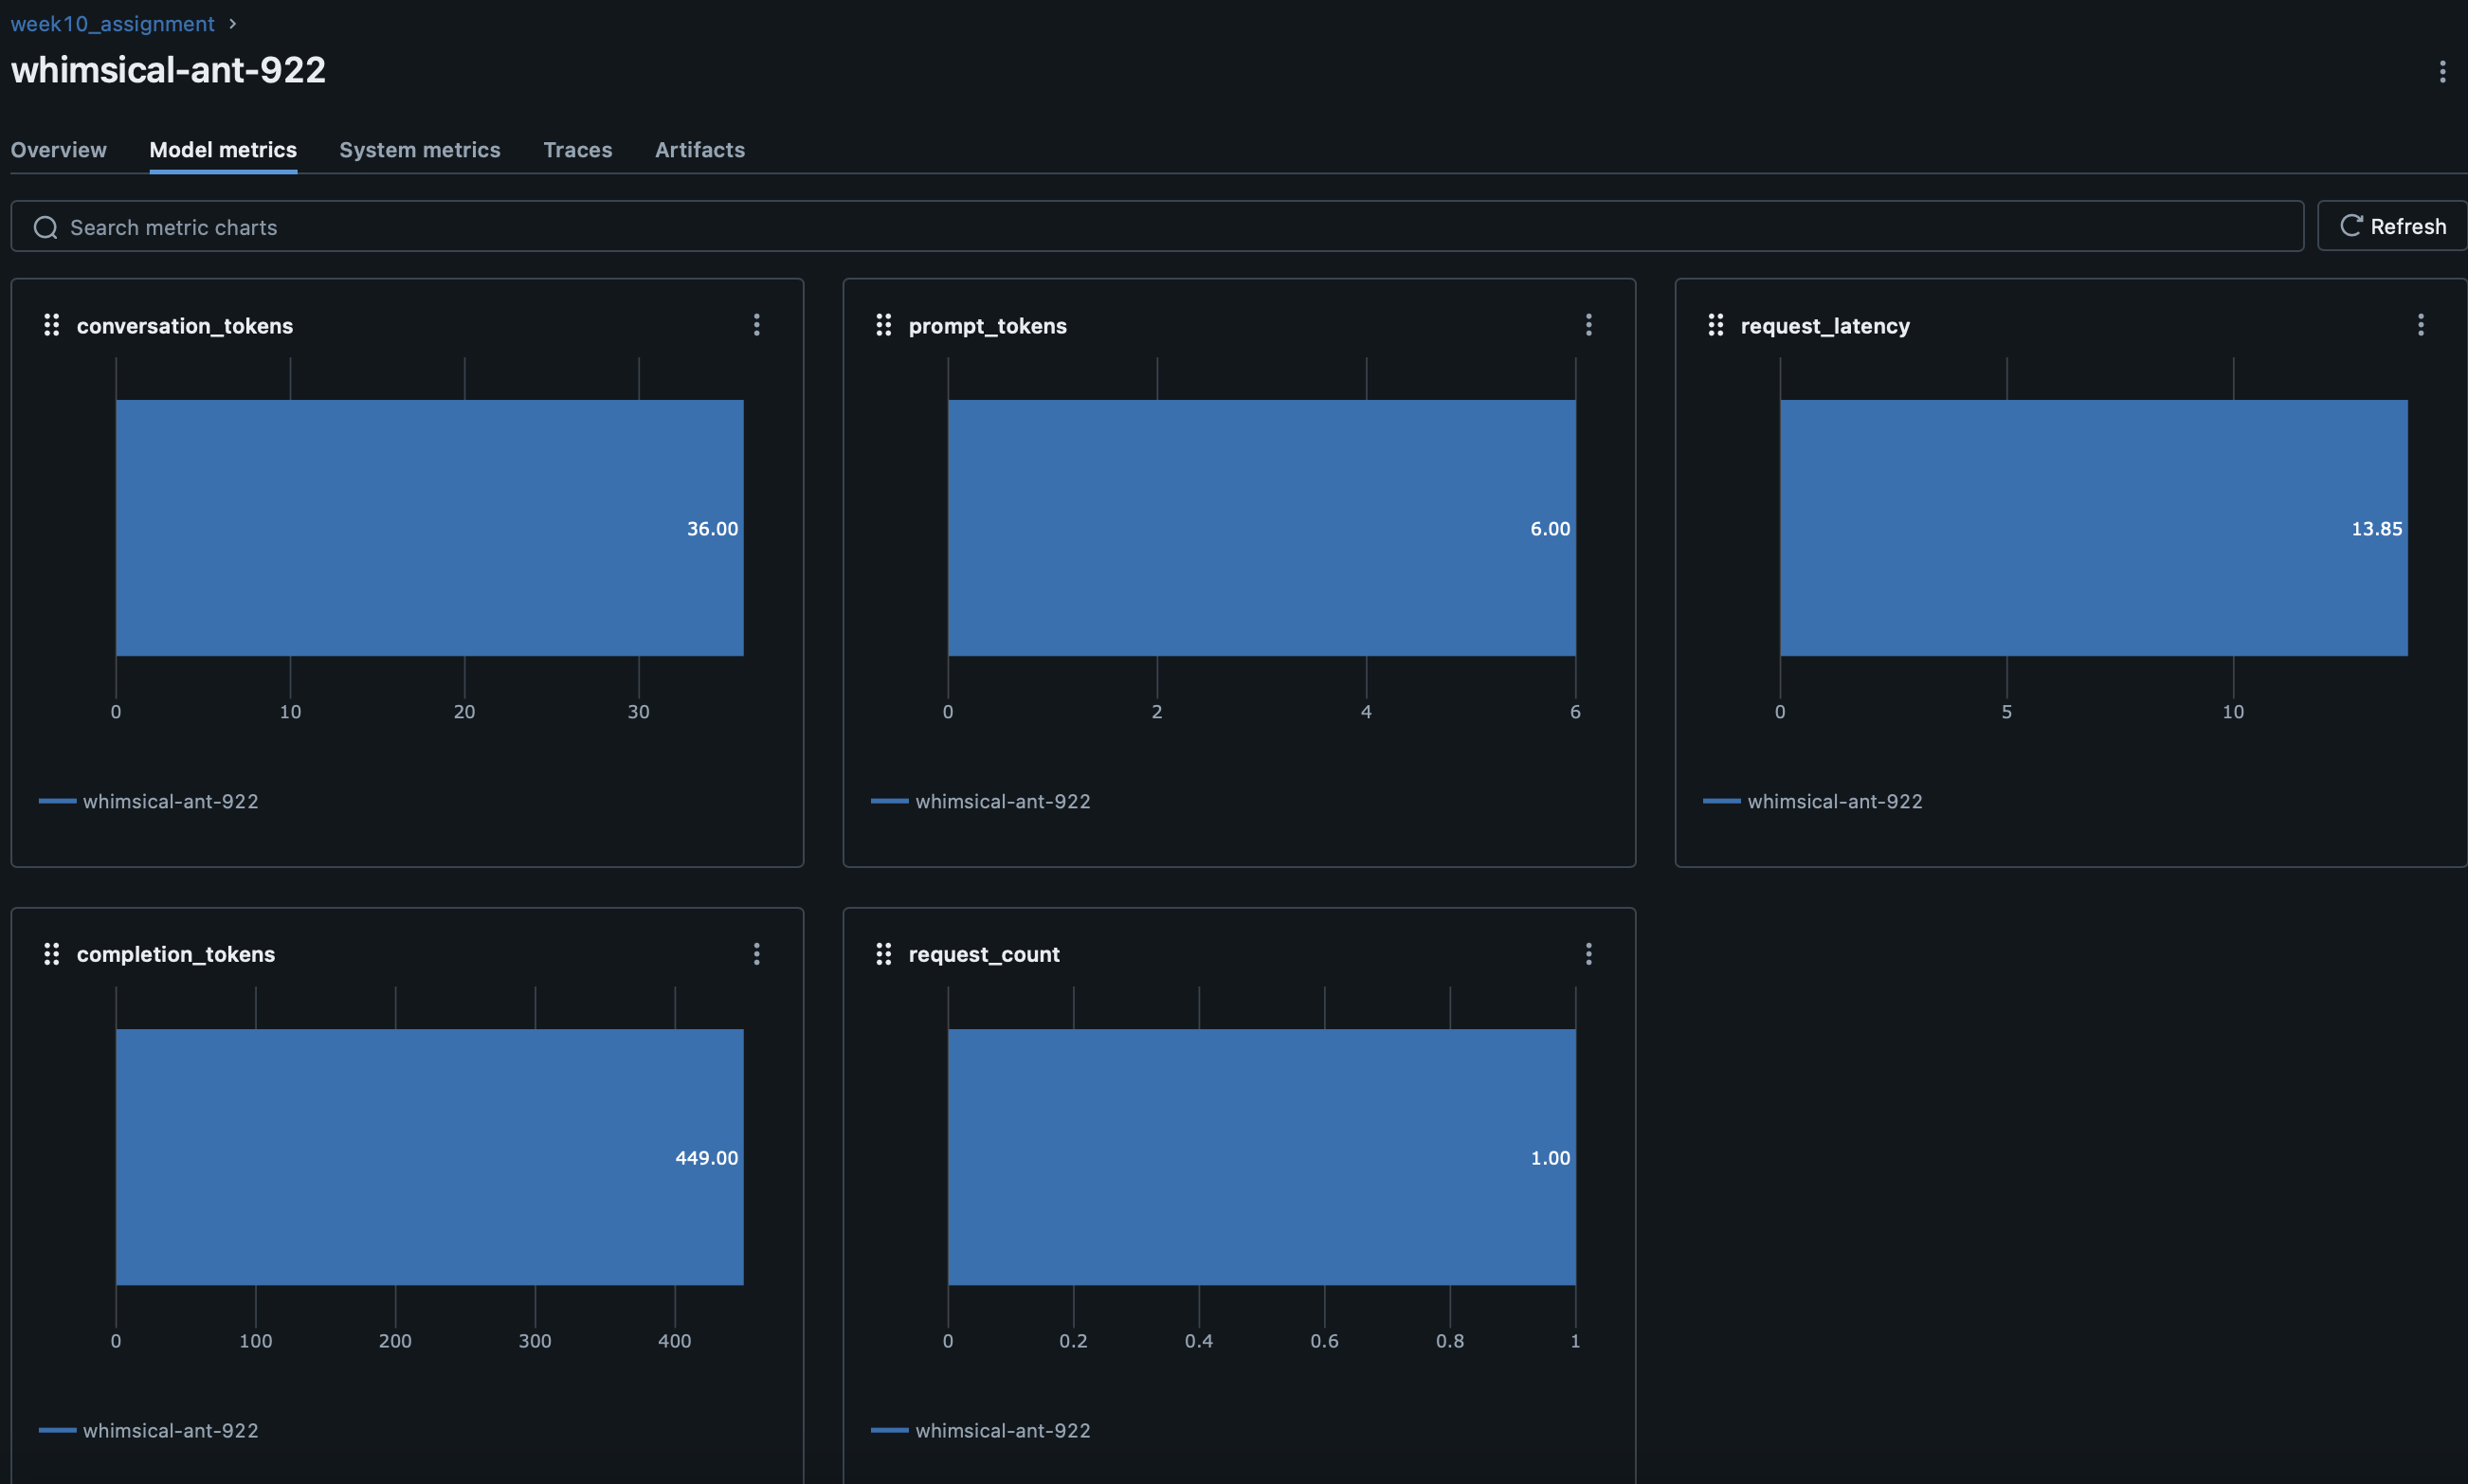